*Copyright (C) 2021 Intel Corporation*<br>
*SPDX-License-Identifier: BSD-3-Clause*<br>
*See: https://spdx.org/licenses/*

---

# Relational networks

This tutorial demonstrates how to set up a relational network with lava-dnf.

Relational networks are a network topology composed of DNFs that enables representing relational features, for example the difference/error between two represented values. In DFT, relational networks are one of the major building blocks of larger architectures, most often employed to implement coordinate transforms between different spaces (e.g., retinal vs. allocentric visual space).

![Diagram relational network](./diagram_relational_network.png)

The figure above illustrates the network topology. Two 1D DNFs, ‘target’ and ‘reference’, are input into a 2D-dimensional ‘transformation’ DNF that represents all possible combinations of the positions in the two DNFs. The 1D DNFs project into the ‘transformation’ DNF, forming subthreshold ridges of activation; only regions in which the ridges overlap form peaks. This activation projects along the diagonal onto the ‘relational’ DNF. The peaks that form there represent the peak-positions in the ‘target’ DNF relative to the position of the peak-position in the ‘reference’ DNF (center of the ‘relational’ DNF).
The diagram visualizes an example with one-dimensional input and output DNFs but the same concept can be applied to higher-dimensional input/output.

In lava-dnf, relational networks can be constructed from basic Lava Processes, like the LIF Processes, and connectivity structures that can be generated with the `connect` function from lava-dnf. The following example demonstrates a relational network with one-dimensional input.
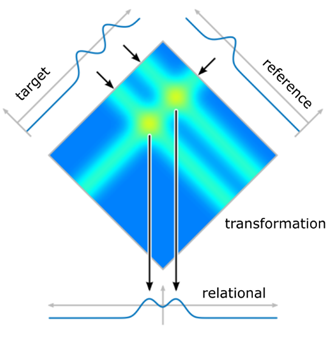

In [9]:
import numpy as np
import matplotlib.pyplot as plt

from lava.magma.core.run_configs import Loihi1SimCfg
from lava.magma.core.run_conditions import RunSteps
from lava.proc.lif.process import LIF
from lava.proc.monitor.process import Monitor

from lava.lib.dnf.connect.connect import connect
from lava.lib.dnf.inputs.gauss_pattern.process import GaussPattern
from lava.lib.dnf.inputs.rate_code_spike_gen.process import \
    RateCodeSpikeGen
from lava.lib.dnf.operations.operations import (
    Weights,
    ExpandDims,
    ReorderDims,
    ReduceAlongDiagonal,
    ExpandAlongDiagonal,
    Flip)

In [10]:
shape = (15,)
shape_relational = tuple(np.array(shape) * 2 - 1)
num_time_steps = 100

# Set up Processes
gauss_target = GaussPattern(shape=shape, amplitude=5000, mean=8, stddev=0.1)
sg_target = RateCodeSpikeGen(shape=shape)

gauss_reference = GaussPattern(shape=shape, amplitude=5000, mean=5, stddev=0.1)
sg_reference = RateCodeSpikeGen(shape=shape)

target = LIF(shape=shape, du=409, dv=2045, vth=200)
reference = LIF(shape=shape, du=409, dv=2045, vth=200)
transformation = LIF(shape=shape + shape, du=409, dv=2045, vth=200)
relational = LIF(shape=shape_relational, du=409, dv=2045, vth=200)

# Connect Processes
gauss_target.a_out.connect(sg_target.a_in)
connect(sg_target.s_out, target.a_in, ops=[Weights(25)])

gauss_reference.a_out.connect(sg_reference.a_in)
connect(sg_reference.s_out, reference.a_in, ops=[Weights(25)])

connect(target.s_out, transformation.a_in,
        ops=[ExpandDims(new_dims_shape=shape[0]),
             Weights(10)])
connect(reference.s_out, transformation.a_in,
        ops=[Flip(),
             ExpandDims(new_dims_shape=shape[0]),
             ReorderDims(order=(1, 0)),
             Weights(10)])
weights_reduce_diag = connect(transformation.s_out, relational.a_in,
                              ops=[ReduceAlongDiagonal(), Weights(25)])
weights_expand_diag = connect(relational.s_out, transformation.a_in,
                              ops=[ExpandAlongDiagonal(), Weights(5)])

# Set up monitors
monitor_target = Monitor()
monitor_target.probe(target.s_out, num_time_steps)

monitor_reference = Monitor()
monitor_reference.probe(reference.s_out, num_time_steps)

monitor_transformation = Monitor()
monitor_transformation.probe(transformation.v, num_time_steps)

monitor_relational = Monitor()
monitor_relational.probe(relational.s_out, num_time_steps)

# Execution
try:
    target.run(condition=RunSteps(num_steps=num_time_steps),
               run_cfg=Loihi1SimCfg(select_tag='bit_accurate_loihi'))

    # Extract data from monitors
    data_target = monitor_target.get_data() \
        [target.name][target.s_out.name].astype(float)

    data_reference = monitor_reference.get_data() \
        [reference.name][reference.s_out.name].astype(float)

    data_transformation = monitor_transformation.get_data() \
        [transformation.name][transformation.v.name].astype(float)

    data_relational = monitor_relational.get_data() \
        [relational.name][relational.s_out.name].astype(float)

    data_weights_reduce_diag = \
        weights_reduce_diag.weights.get().astype(float)
    data_weights_expand_diag = \
        weights_expand_diag.weights.get().astype(float)
finally:
    target.stop()

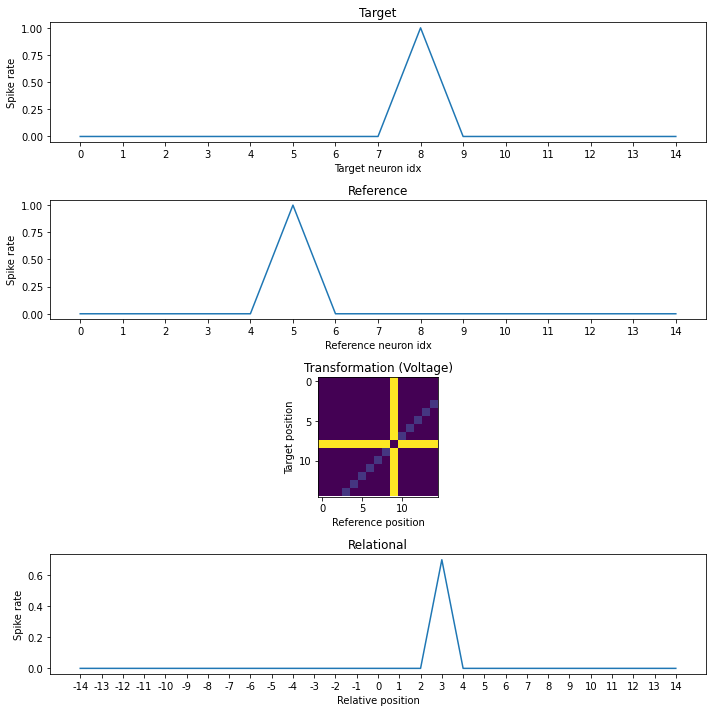

In [11]:
# Plot data
_num_neurons = shape[0]
_num_neurons_relational = shape_relational[0]

plt.figure(figsize=(10, 10))
ax0 = plt.subplot(4, 1, 1)
ax0.plot(np.mean(data_target[50:70, :], axis=0))
ax0.set_xlabel('Target neuron idx')
ax0.set_ylabel('Spike rate')
ax0.set_xticks(range(_num_neurons))
ax0.set_title('Target')

ax1 = plt.subplot(4, 1, 2)
ax1.plot(np.mean(data_reference[50:70, :], axis=0))
ax1.set_xlabel('Reference neuron idx')
ax1.set_ylabel('Spike rate')
ax1.set_xticks(range(_num_neurons))
ax1.set_title('Reference')

ax2 = plt.subplot(4, 1, 3)
ax2.imshow(np.mean(data_transformation[50:70, :],
                   axis=0).reshape(shape + shape))
ax2.set_title('Transformation (Voltage)')
ax2.set_xlabel('Reference position')
ax2.set_ylabel('Target position')
ax2.set_xticks(range(0, _num_neurons, 5))
ax2.set_yticks(range(0, _num_neurons, 5))

ax3 = plt.subplot(4, 1, 4)
ax3.plot(np.mean(data_relational[50:70], axis=0))
ax3.set_xlabel('Relative position')
ax3.set_ylabel('Spike rate')
ax3.set_title('Relational')
plt.xticks(ticks=range(_num_neurons_relational),
           labels=range(-int(_num_neurons_relational/2),
                        int(_num_neurons_relational/2) + 1))

plt.tight_layout()
plt.show()

## Bidirectional connectivity
The diagram at the beginning of this tutorial depicts a relational network with connections that flow in only one direction, toward the relational DNF. Relational networks can also be set up with bidirectional connectivity, coupling all four DNFs in both directions. This enables reading out the target (or reference) position given both the relative position and the reference (or target) position.

The Lava implementation demonstrates how to set up connectivity from the relational DNF to the transformation DNF, which results in the faint diagonal line in the plot of the transformation DNF. A complete bidirectional DNF would additionally have connections from the transformation DNF to the target and reference DNFs.

## Diagonal projection operations

The two operations that enable the diagonal projections between the relational DNF and the transformation DNF are the `ReduceAlongDiagonal` (toward relational DNF) and `ExpandAlongDiagonal` (toward transformation DNF). The connectivity matrix produced by the operation `ReduceAlongDiagonal` sums the spike output of the transformation DNF along its diagonaland is shown below for the network demonstrated above.

Text(0, 0.5, 'Neuron idx relational DNF')

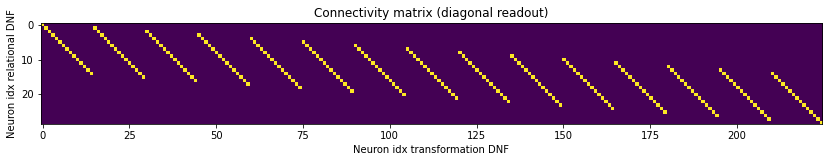

In [12]:
plt.figure(figsize=(14, 14))
plt.imshow(data_weights_reduce_diag)
plt.title('Connectivity matrix (diagonal read-out)')
plt.xlabel('Neuron idx transformation DNF')
plt.ylabel('Neuron idx relational DNF')

The operation `ExpandAlongDiagonal` produces a connectivity matrix that projects the spike output of the relational DNF into the transformation DNF along its diagonal. The connectivity matrix is shown below.

Text(0, 0.5, 'Neuron idx transformation DNF')

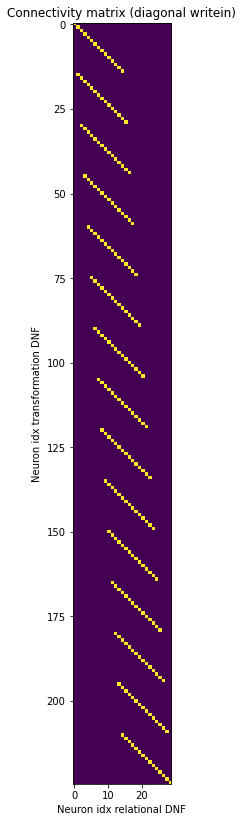

In [13]:
plt.figure(figsize=(14, 14))
plt.imshow(data_weights_expand_diag)
plt.title('Connectivity matrix (diagonal write-in)')
plt.xlabel('Neuron idx relational DNF')
plt.ylabel('Neuron idx transformation DNF')